In [1]:
import math
from collections import OrderedDict
from functools import lru_cache

import duckdb
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
# Hack to get around import issues
layers = keras.layers

In [2]:


conn = duckdb.connect("timeball.db")

@lru_cache(maxsize=100)
def get_string_encoder(feature_name, use_ordinal=False) -> layers.StringLookup:
    if feature_name == "player_id":
        query = "SELECT retrosheet_player_id FROM main_models.stg_people WHERE retrosheet_player_id IS NOT NULL ORDER BY 1"
        vocabulary = conn.sql(query).fetchdf()["retrosheet_player_id"].tolist()
        oov_token = "N/A"
    else:
        query = f"SELECT DISTINCT {feature_name} FROM main_models.ml_features ORDER BY 1"
        vocabulary = conn.sql(query).fetchdf()[feature_name].tolist()
        oov_token = None
    return layers.StringLookup(
        vocabulary=vocabulary,
        oov_token=oov_token,
        mask_token=None,
        num_oov_indices=0 if oov_token is None else 1,
        output_mode="int" if use_ordinal else "one_hot",
    )

OUTCOMES = {
    "outcome_has_batting_bin": "generic_sample_weight",
    "outcome_is_in_play_bin": "in_play_sample_weight",
    "outcome_batted_contact_cat": "contact_sample_weight",
    "outcome_batted_location_cat": "location_sample_weight",
    "outcome_plate_appearance_cat": "plate_appearance_sample_weight",
    "outcome_baserunning_cat": "baserunning_play_sample_weight",
    "outcome_runs_following_num": "generic_sample_weight",
    "outcome_is_win_bin": "win_sample_weight",
}
OUTCOME_ENCODERS = {
    outcome: get_string_encoder(outcome)
    for outcome in OUTCOMES if outcome.endswith("_cat")
}
OUTCOME_CLASS_COUNTS = {
    outcome: len(encoder.get_vocabulary())
    for outcome, encoder in OUTCOME_ENCODERS.items()
}

/Users/davidroher/.pyenv/versions/3.11.1/lib/python3.11/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
2023-09-26 20:37:47.707969: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-09-26 20:37:47.707988: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-09-26 20:37:47.707992: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-09-26 20:37:47.708168: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-26 20:37:47.708181: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) ->

In [3]:



def map_to_keras_input(x: dict[str, tf.Tensor]) -> (OrderedDict[str, tf.Tensor], ...):
    x = OrderedDict(x)
    for k, v in x.items():
        if k.endswith("_cat"):
            x[k] = tf.strings.as_string(v)
    targets = OrderedDict()
    weights = OrderedDict()
    for target_col, weight_col in OUTCOMES.items():
        weights[target_col] = x[weight_col]
        if target_col.endswith("_cat"):
            targets[target_col] = OUTCOME_ENCODERS[target_col](x[target_col])
        else:
            targets[target_col] = x[target_col]
    return x, targets, weights

def df_to_dataset(df) -> (OrderedDict[str, tf.Tensor], ...):
    df_dict = {col: np.expand_dims(df[col], axis=0) for col in df.columns}
    ds = tf.data.Dataset.from_tensor_slices(df_dict)
    return ds.map(map_to_keras_input)

def get_query_output_signature(query: str, batch_size: int) -> tf.data.DatasetSpec:
    df = conn.sql(query).limit(batch_size).df()
    return df_to_dataset(df).element_spec

def duckdb_generator(query: str, batch_size=256, batches_to_grab=10):
    cursor = conn.cursor()
    cursor.execute(query)
    batch_reader = cursor.fetch_record_batch(rows_per_batch=batch_size * batches_to_grab)
    for batch in batch_reader:
        df = batch.to_pandas()
        chunks = [df.iloc[i:i + batch_size] for i in range(0, df.shape[0], batch_size)]
        for chunked_df in chunks:
            if chunked_df.shape[0] < batch_size:
                break
            ds = df_to_dataset(chunked_df)
            for x, y, z in ds:
                # Print dtypes
                yield x, y, z
        # Try to free memory
        del(df, ds, chunks)

def duckdb_to_dataset(query: str, batch_size=256) -> tf.data.Dataset:
    ds = tf.data.Dataset.from_generator(
        lambda: duckdb_generator(query, batch_size),
        output_signature=get_query_output_signature(query, batch_size),
    )
    return ds


In [4]:
col_names = conn.sql("SELECT * FROM main_models.ml_features LIMIT 1").df().columns.tolist()

# Get all columns that are floats except ones that start with "outcome"
NUMERIC_FEATURE_NAMES = [col for col in col_names if not col.startswith("outcome") and col.endswith("_num")]

CATEGORICAL_FEATURE_NAMES = [col for col in col_names if not col.startswith("outcome") and col.endswith("_cat")]

PLAYER_FEATURE_NAMES = [col for col in col_names if col.endswith("_player")]

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES + PLAYER_FEATURE_NAMES

In [5]:
class CategoricalMetrics(tf.keras.metrics.Metric):
    def __init__(self, target_encoder: layers.StringLookup, update_freq=10, **kwargs):
        super().__init__(**kwargs)
        self.vocabulary = target_encoder.get_vocabulary()
        self.num_classes = target_encoder.vocabulary_size()
        self.update_freq = update_freq
        if target_encoder.oov_token is not None:
            self.num_classes -= 1  # Exclude the OOV token if present

        self.auc_metrics = [tf.keras.metrics.AUC(name=f"auc_{i}") for i in range(self.num_classes)]
        self.batch_counter = self.add_weight("batch_counter", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.batch_counter.assign_add(1)
        for i in range(self.num_classes):
            self.auc_metrics[i].update_state(y_true[:, i], y_pred[:, i], sample_weight=sample_weight)

    def result(self):
        class_metrics = {}
        for i in range(self.num_classes):
            class_name = self.vocabulary[i]
            auc = self.auc_metrics[i].result()

            class_metrics[f"auc_{class_name}"] = auc

        return class_metrics

    def reset_state(self):
        self.batch_counter.assign(0)
        for i in range(self.num_classes):
            self.auc_metrics[i].reset_state()


In [6]:
start_learning_rate = 0.01
dropout_rate = 0.5
batch_size = 2048
num_epochs = 1

hidden_units = [256, 128, 64]

def learning_rate_scheduler(epoch):
    return max(start_learning_rate / math.pow(2, epoch), .0001)


learning_rate_callback = keras.callbacks.LearningRateScheduler(learning_rate_scheduler)
stopping_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True, verbose=2)
nan_callback = keras.callbacks.TerminateOnNaN()
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=100, write_images=True, update_freq="batch",
#                                                    profile_batch=1, embeddings_freq=100, embeddings_metadata="embedding_metadata.tsv")


def run_experiment(model: keras.Model, train_dataset, test_dataset):
    cat_loss_dict = {outcome: keras.losses.CategoricalFocalCrossentropy() for outcome in OUTCOME_ENCODERS}
    bin_loss_dict = {outcome: keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True) for outcome in OUTCOMES if outcome.endswith("_bin")}
    num_loss_dict = {outcome: keras.losses.MeanSquaredError() for outcome in OUTCOMES if outcome.endswith("_num")}
    loss_dict = {**cat_loss_dict, **bin_loss_dict, **num_loss_dict}
    cat_metrics_dict = {outcome: CategoricalMetrics(encoder) for outcome, encoder in OUTCOME_ENCODERS.items()}
    bin_metrics_dict = {outcome: [keras.metrics.AUC()] for outcome in OUTCOMES if outcome.endswith("_bin")}
    num_metrics_dict = {}
    metrics_dict = {**cat_metrics_dict, **bin_metrics_dict, **num_metrics_dict}
    
    cat_weight_list = [1 for outcome in OUTCOME_ENCODERS]
    bin_weight_list = [10 for outcome in OUTCOMES if outcome.endswith("_bin")]
    num_weight_list = [1 for outcome in OUTCOMES if outcome.endswith("_num")]
    loss_weights = cat_weight_list + bin_weight_list + num_weight_list

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=loss_dict,
        weighted_metrics=metrics_dict,
        loss_weights=loss_weights,
    )

    model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset,
              callbacks=[stopping_callback, nan_callback, learning_rate_callback])

    print("Model training finished")
    model.evaluate(test_dataset)


In [7]:
# https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.take(int(10000 * (1/ batch_size)) + 1).map(lambda x, y, z: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

def create_player_layers(inputs):
    lookup = get_string_encoder("player_id", use_ordinal=True)
    embedding_dim = int(math.sqrt(lookup.vocabulary_size()))
    shared_player_embedding = layers.Embedding(
        input_dim=lookup.vocabulary_size(),
        output_dim=embedding_dim
    )
    shared_layers = [shared_player_embedding(lookup(inputs[feature])) for feature in PLAYER_FEATURE_NAMES]

    return shared_layers

def encode_inputs(inputs, dataset):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            lookup = get_string_encoder(feature_name, use_ordinal=True)
            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])
            embedding_dims = int(math.sqrt(lookup.vocabulary_size()))
            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=lookup.vocabulary_size(), output_dim=embedding_dims
            )
            # Convert the index values to embedding representations.
            encoded_feature = embedding(encoded_feature)
        elif feature_name in NUMERIC_FEATURE_NAMES:
            # Normalize the numeric features with the Normalization layer
            print(f"Normalizing {feature_name}")
            normalizer = get_normalization_layer(feature_name, dataset)
            normalized_feature = normalizer(inputs[feature_name])
            encoded_feature = tf.expand_dims(normalized_feature, -1)

        encoded_features.append(encoded_feature)
    encoded_features.extend(create_player_layers(inputs))

    all_features = layers.concatenate(encoded_features)
    return all_features

def create_deep_and_cross_model(dataset):
    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, dataset)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.Activation("relu")(deep)
        if num_epochs > 1:
            deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    cat_outcomes = [layers.Dense(units=OUTCOME_CLASS_COUNTS[outcome], activation="softmax", name=outcome)(merged) for outcome in OUTCOME_ENCODERS]
    bin_outcomes = [layers.Dense(units=1, activation="sigmoid", name=outcome)(merged) for outcome in OUTCOMES if outcome.endswith("_bin")]
    num_outcomes = [layers.Dense(units=1, name=outcome)(merged) for outcome in OUTCOMES if outcome.endswith("_num")]
    model = keras.Model(inputs=inputs, outputs=[*cat_outcomes, *bin_outcomes, *num_outcomes])
    return model

In [8]:
# Data is pre-shuffled
train = duckdb_to_dataset("SELECT * FROM main_models.ml_features WHERE meta_train_test_split = 'TRAIN'", batch_size=batch_size)
test = duckdb_to_dataset("SELECT * FROM main_models.ml_features WHERE meta_train_test_split = 'TEST'", batch_size=batch_size)
model = create_deep_and_cross_model(train)

Normalizing season_num


2023-09-26 20:37:48.528676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 20:37:48.545290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 20:37:49.716485: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7180705955485190931
2023-09-26 20:37:49.716778: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16100931673188713968


Normalizing day_of_year_num


2023-09-26 20:37:49.966368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 20:37:49.980431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 20:37:51.140739: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7180705955485190931
2023-09-26 20:37:51.140756: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16100931673188713968
2023-09-26 20:37:51.247257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 20:37:51.261049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Normalizing inning_num


2023-09-26 20:37:52.414345: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7180705955485190931
2023-09-26 20:37:52.414363: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16100931673188713968
2023-09-26 20:37:52.595007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 20:37:52.609026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Normalizing frame_num


2023-09-26 20:37:53.781711: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7180705955485190931
2023-09-26 20:37:53.781730: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16100931673188713968
2023-09-26 20:37:53.888899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 20:37:53.902717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Normalizing is_night_game_num


2023-09-26 20:37:55.060446: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7180705955485190931
2023-09-26 20:37:55.060464: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16100931673188713968
2023-09-26 20:37:55.178321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 20:37:55.191819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Normalizing score_batting_team_num


2023-09-26 20:37:56.355725: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7180705955485190931
2023-09-26 20:37:56.355745: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16100931673188713968
2023-09-26 20:37:56.466482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 20:37:56.480188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Normalizing score_fielding_team_num


2023-09-26 20:37:57.650971: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7180705955485190931
2023-09-26 20:37:57.650992: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16100931673188713968
/Users/davidroher/.pyenv/versions/3.11.1/lib/python3.11/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


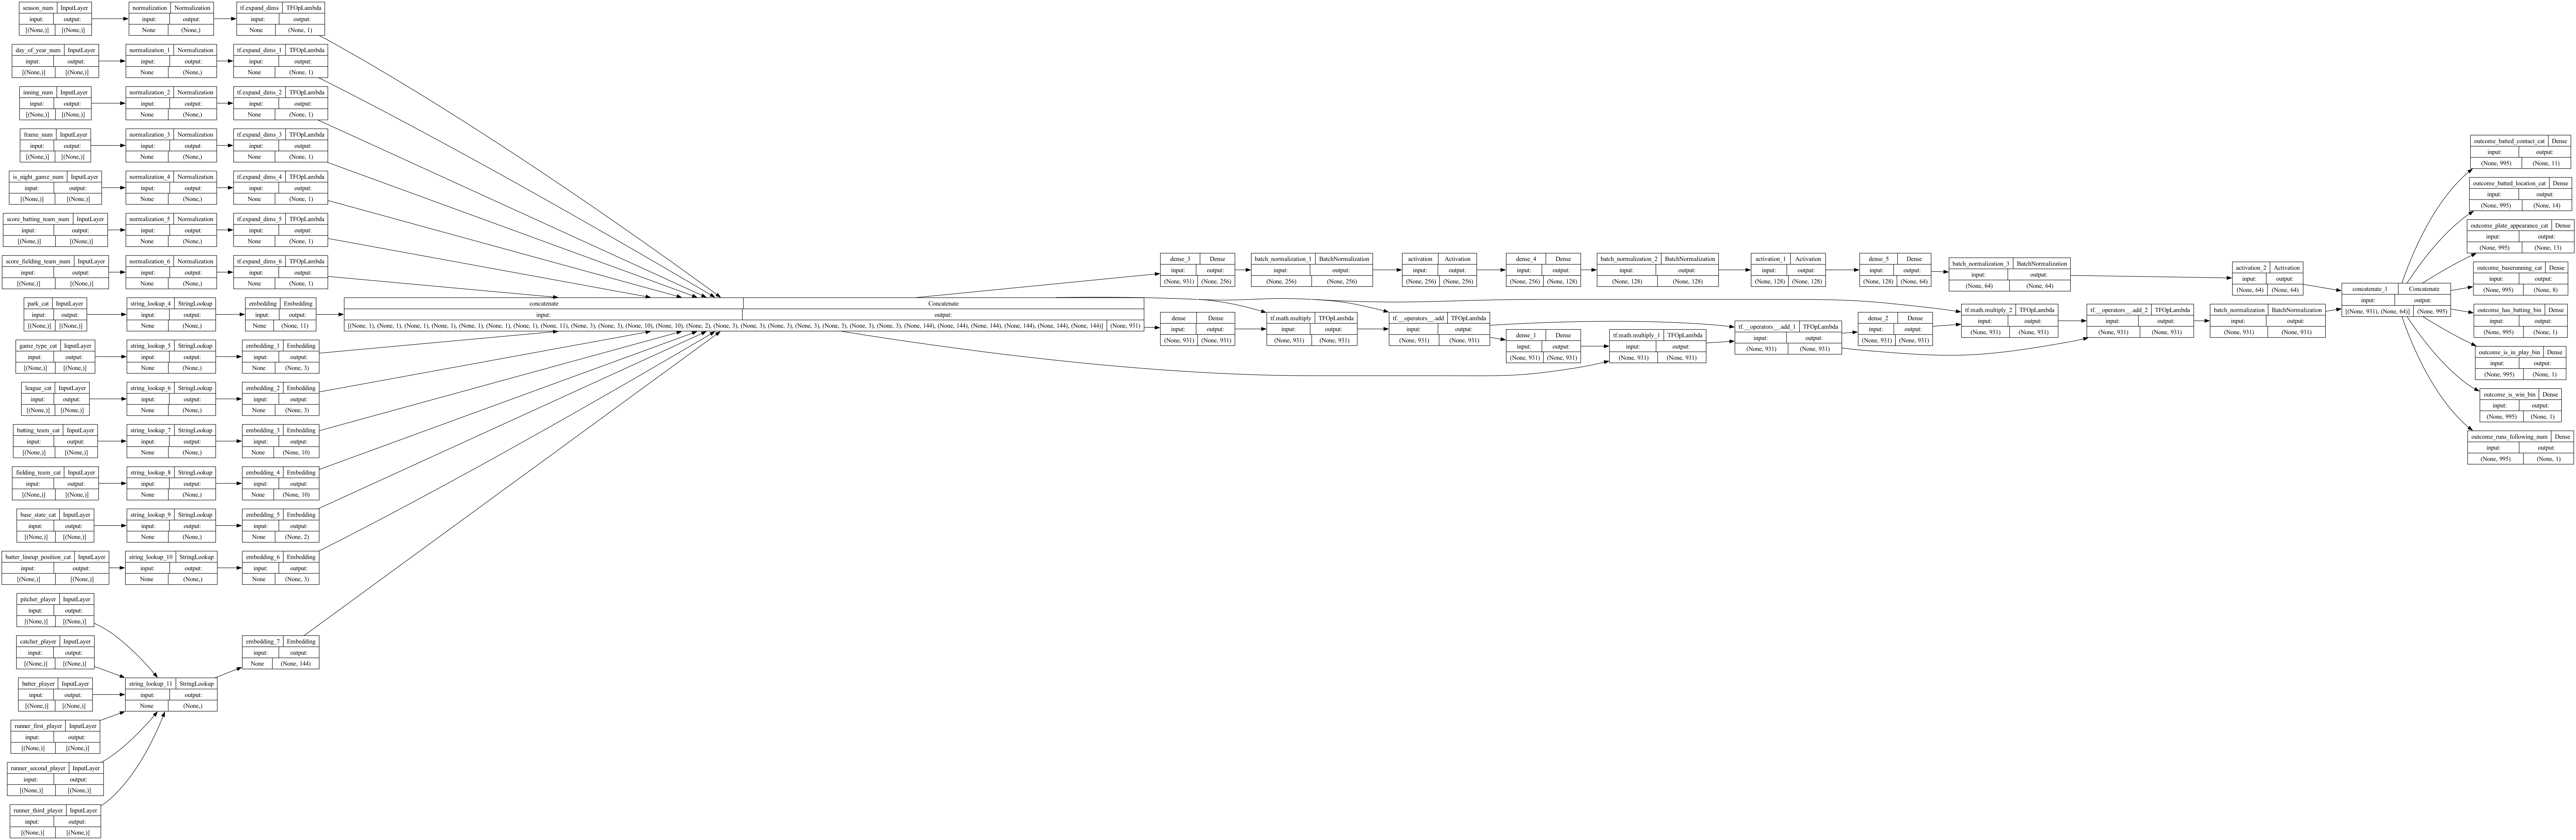

In [9]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [10]:
run_experiment(model, train_dataset=train, test_dataset=test)
y_pred = model.predict(test)


/Users/davidroher/.pyenv/versions/3.11.1/lib/python3.11/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['event_key', 'outcome_has_batting_bin', 'outcome_is_in_play_bin', 'outcome_batted_contact_cat', 'outcome_batted_location_cat', 'outcome_plate_appearance_cat', 'outcome_baserunning_cat', 'outcome_runs_following_num', 'outcome_is_win_bin', 'generic_sample_weight', 'plate_appearance_sample_weight', 'in_play_sample_weight', 'contact_sample_weight', 'location_sample_weight', 'baserunning_play_sample_weight', 'win_sample_weight', 'meta_train_test_split'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2023-09-26 20:38:05.552084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


   7217/Unknown - 4670s 634ms/step - loss: 3.1626 - outcome_batted_contact_cat_loss: 0.1712 - outcome_batted_location_cat_loss: 0.3236 - outcome_plate_appearance_cat_loss: 0.2594 - outcome_baserunning_cat_loss: 0.2331 - outcome_has_batting_bin_loss: 0.0153 - outcome_is_in_play_bin_loss: 0.0604 - outcome_is_win_bin_loss: 0.0432 - outcome_runs_following_num_loss: 0.9859 - auc_Fly: 0.5510 - auc_FoulBunt: 0.4892 - auc_GroundBall: 0.5500 - auc_GroundBallBunt: 0.7392 - auc_LineDrive: 0.6830 - auc_LineDriveBunt: 0.5062 - auc_Other: 0.0000e+00 - auc_PopFly: 0.5882 - auc_PopUpBunt: 0.6470 - auc_Unknown: 0.0000e+00 - auc_UnspecifiedBunt: 0.6660 - auc_Battery-All: 0.6302 - auc_Battery-Left: 0.5011 - auc_Battery-Right: 0.4960 - auc_Infield-Left: 0.5728 - auc_Infield-Middle: 0.5359 - auc_Infield-Right: 0.5799 - auc_Outfield-Left: 0.5579 - auc_Outfield-Middle: 0.5433 - auc_Outfield-Right: 0.5625 - auc_Unknown-Left: 0.0000e+00 - auc_Unknown-Middle: 0.0000e+00 - auc_Unknown-Right: 0.0000e+00 - auc_Unk

2023-09-26 21:55:52.112126: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 5061516374552289244
2023-09-26 21:55:52.112724: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16374449214226276734
2023-09-26 21:55:52.112988: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 2315924263448420830
2023-09-26 21:55:52.112995: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 31944858230195068
2023-09-26 21:55:52.112999: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14140756595138345530
2023-09-26 21:55:52.113007: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1790560199400768736
2023-09-26 21:55:52.113012: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv ite

7217/7217 [==============================] - 4843s 658ms/step - loss: 3.1626 - outcome_batted_contact_cat_loss: 0.1712 - outcome_batted_location_cat_loss: 0.3236 - outcome_plate_appearance_cat_loss: 0.2594 - outcome_baserunning_cat_loss: 0.2331 - outcome_has_batting_bin_loss: 0.0153 - outcome_is_in_play_bin_loss: 0.0604 - outcome_is_win_bin_loss: 0.0432 - outcome_runs_following_num_loss: 0.9859 - auc_Fly: 0.5510 - auc_FoulBunt: 0.4892 - auc_GroundBall: 0.5500 - auc_GroundBallBunt: 0.7392 - auc_LineDrive: 0.6830 - auc_LineDriveBunt: 0.5062 - auc_Other: 0.0000e+00 - auc_PopFly: 0.5882 - auc_PopUpBunt: 0.6470 - auc_Unknown: 0.0000e+00 - auc_UnspecifiedBunt: 0.6660 - auc_Battery-All: 0.6302 - auc_Battery-Left: 0.5011 - auc_Battery-Right: 0.4960 - auc_Infield-Left: 0.5728 - auc_Infield-Middle: 0.5359 - auc_Infield-Right: 0.5799 - auc_Outfield-Left: 0.5579 - auc_Outfield-Middle: 0.5433 - auc_Outfield-Right: 0.5625 - auc_Unknown-Left: 0.0000e+00 - auc_Unknown-Middle: 0.0000e+00 - auc_Unknown-

2023-09-26 21:59:38.587393: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16958759351528842742
2023-09-26 21:59:38.587430: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7879681907395962410
2023-09-26 21:59:38.587437: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11245777401767831174
2023-09-26 21:59:38.587442: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16414259852494136698
2023-09-26 21:59:38.587447: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 2768627561022884840
2023-09-26 21:59:38.587453: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 291468851884117378
2023-09-26 21:59:38.587458: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv i

149/149 [==============================] - 35s 175ms/step


2023-09-26 22:00:13.631707: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4980743022901082147
2023-09-26 22:00:13.631734: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15317729163851114791
2023-09-26 22:00:13.631739: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 72988224681282343
2023-09-26 22:00:13.631744: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9150072719214582813
2023-09-26 22:00:13.631756: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17176064060332372212
2023-09-26 22:00:13.631760: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1829466384779841270
2023-09-26 22:00:13.631765: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv ite

    768/Unknown - 291s 366ms/step - loss: 2.2247 - outcome_batted_contact_cat_loss: 0.1917 - outcome_batted_location_cat_loss: 0.3445 - outcome_plate_appearance_cat_loss: 0.2794 - outcome_baserunning_cat_loss: 0.2511 - outcome_has_batting_bin_loss: 0.0177 - outcome_is_in_play_bin_loss: 0.0628 - outcome_is_win_bin_loss: 0.0551 - outcome_runs_following_num_loss: 1.0223 - auc_Fly: 0.5267 - auc_FoulBunt: 0.3034 - auc_GroundBall: 0.5212 - auc_GroundBallBunt: 0.6439 - auc_LineDrive: 0.6467 - auc_LineDriveBunt: 0.5273 - auc_Other: 0.0000e+00 - auc_PopFly: 0.5619 - auc_PopUpBunt: 0.5444 - auc_Unknown: 0.0000e+00 - auc_UnspecifiedBunt: 0.5771 - auc_Battery-All: 0.5995 - auc_Battery-Left: 0.5009 - auc_Battery-Right: 0.4967 - auc_Infield-Left: 0.5189 - auc_Infield-Middle: 0.5161 - auc_Infield-Right: 0.5172 - auc_Outfield-Left: 0.5287 - auc_Outfield-Middle: 0.5259 - auc_Outfield-Right: 0.5310 - auc_Unknown-Left: 0.0000e+00 - auc_Unknown-Middle: 0.0000e+00 - auc_Unknown-Right: 0.0000e+00 - auc_Unknown-Unknown: 0.0000e+00 - auc_Double: 0.5216 - auc_HitByPitch: 0.5182 - auc_HomeRun: 0.5877 - auc_InPlayOut: 0.5408 - auc_IntentionalWalk: 0.8820 - auc_ReachedOnError: 0.7365 - auc_SacrificeFly: 0.8660 - auc_SacrificeHit: 0.8152 - auc_Single: 0.5168 - auc_StrikeOut: 0.5960 - auc_Triple: 0.5321 - auc_Walk: 0.5401 - auc_CaughtStealing: 0.6455 - auc_OtherAdvanceOut: 0.6021 - auc_OtherAdvanceSafe: 0.6078 - auc_PassedBall: 0.6177 - auc_PickedOff: 0.5547 - auc_StolenBase: 0.6166 - auc_WildPitch: 0.6840 - outcome_has_batting_bin_auc: 0.8325 - outcome_is_in_play_bin_auc_1: 0.5865 - outcome_is_win_bin_auc_2: 0.8202 - outcome_runs_following_num_r2_score: 0.0402